# Optimize a prompt that maximizes win rate

Given
- a certified judge classifier `JUDGE_CLASSIFICATION_PROMPT: str`
- some input string data samples `INPUT_DATA_SAMPLES: tuple[str]`
- initial prompt `INITIAL_GENERATION_PROMPT: str`

Produce
- a prompt with a good winrate (measured by the judge) against other prompts

## Example use case presented in this notebook

Given a Quora answer, write followup questions to the answer.

Great followup questions should be appealing to respond to and answers should be appealing to read.

## Foreword

Think of how the project manager interacts with the prompt engineer.

The project manager does not need to provide examples of good output, just the criteria of what good output should be.

Inspirations

- Anthropic workbench https://console.anthropic.com/workbench/
- Cohere prompt tuner https://cohere.com/blog/intro-prompt-tuner

## Frequently asked questions

Why don't you use the judge prompt in the generation prompt?
- You can if you want. I expect models in the future to be iteratively think of the best reponse by iterative brainstorming responses and think which is the response is the best. The idea of prompt engineering is to get the model to learn the shortcut (output tokens are not free).

Why don't you tune the `JUDGE_CLASSIFICATION_PROMPT`?
- In this tool we assume that we trust `JUDGE_CLASSIFICATION_PROMPT`. You should tune this elsewhere.

In [1]:
from functools import cache

import anthropic
client = anthropic.Anthropic()

# Inputs for the tool user

In [2]:
import pandas as pd
df = pd.read_csv("source_questions_and_answers.csv")
df.head(2)

,source_question_and_answer
0,How would you rate the success of the Olympic ...
1,"Who is more of a pure talent, Lebron or Curry?..."


In [3]:
INPUT_DATA_SAMPLES: tuple[str] = tuple(df["source_question_and_answer"])
source_questions_and_answers = INPUT_DATA_SAMPLES

In [4]:
INITIAL_GENERATION_PROMPT = """
You are given the following source question and a source answer.

<source_question_and_answer>
{source_question_and_answer}
</source_question_and_answer>

Write between 3 to 5 followup questions to the answer.

Return each question between <question> and </question>
""".strip()

In [5]:
JUDGE_CLASSIFICATION_PROMPT = """
You are given an answer and two sets of followup questions.

Determine which set of followup questions is better.

The better set of followup questions should have these characteristics
- Each question could be understood without context
- Each question should be written concisely
- Each question should appear between <question> and </question>
- There should be between 3 to 5 questions.
- Each question should be distinct.

This is the source question and source answer
<source_question_and_answer>
{source_question_and_answer}
</source_question_and_answer>

This is the first set of followup questions

{followup_questions_one}

This is the second set of followup questions

{followup_questions_two}

Write some concise reasoning, end your response with one for the follow
- Set <label>one</label> is better.
- Set <label>two</label> is better.
- Both sets <label>tie</label>.
""".strip()

# Judge classification prompt

In [6]:
# We assume that we trust this prompt
judge_classification_prompt = JUDGE_CLASSIFICATION_PROMPT

def judge_classification(
    source_question_and_answer: str,
    followup_questions_one: str,
    followup_questions_two: str,
) -> tuple[str, str]:
    # return either one, two or tie
    
    message = client.messages.create(
        model="claude-3-5-sonnet-20241022",
        max_tokens=1024,
        messages=[
            {
                "role": "user", 
                "content": judge_classification_prompt.format(
                    source_question_and_answer=source_question_and_answer,
                    followup_questions_one=followup_questions_one,
                    followup_questions_two=followup_questions_two,
                )
            },
        ]
    )
    message_text = message.content[0].text
    if "<label>one</label>" in message_text:
        return message_text, "one"
    if "<label>one</label>" in message_text:
        return message_text, "two"
    return message_text, "tie"

In [7]:
source_question_and_answer = """
Who is more of a pure talent, Lebron or Curry?

I saw a recent interview with Team USA, where basketball players shared when they first dunked. Some guys dunked at 11 or 12. A few were “late bloomers” who didn’t dunk until 17. Steph didn’t dunk until he was 19 years old.

This kid’s never survived on talent. Never. He’s 6′3″ with shoes, four inches shorter than the NBA average. He’s got a solid vertical (35.5″) but would never have made it to the NBA if not for his shooting ability. His height plus his less “glamorous” college career made him a risky first-round pick. The Warriors grabbed him with the 7th pick. They had no idea

Compare that to LeBron.

He was a 6′7″ 16-year-old and unstoppable in high school. His numbers were unreal—not just the scoring, either, but the rebounding and passing, too. LeBron clocked a vertical north of 40 inches, more than enough to dunk on anybody in the league. The King didn’t need to really workshop his shooting until several years into his career. That’s talent.

I mean no disrespect to either player. Steph’s still very talented and LeBron still put a LOT of work in. But if they both won the genetic lottery, Steph won $10 million and LeBron won $100 million. Guys like Steph happen. They just rarely have the same shooting foundation (thanks to an NBA father) and work ethic to pull off his career. Guys like LeBron are much rarer. But neither could have survived with just talent or skill. That’s no longer possible in the league.
""".strip()

followup_questions_one = """
<question>How do basketball players with high vertical leaps compare to those with less-than-average verticals?</question>

<question>Is work ethic more important than natural talent in basketball?</question>

<question>What are some examples of athletes who overcame physical limitations to achieve success?</question>

<question>How important is it for basketball players to have a solid foundation in shooting?</question>

<question>How has the role of talent and skill evolved in the NBA over time?</question>
"""

followup_questions_two = """
1. <question>How has the balance between natural talent and skill development evolved in the NBA over the past few decades, and are there other examples that illustrate this shift?</question>

2. <question>You mentioned Curry's NBA father providing a shooting foundation - can you elaborate on other successful NBA players who had to overcome physical limitations through specialized skills passed down from family members?</question>

3. <question>In your genetic lottery analogy, where would you place other current NBA superstars on the spectrum between Curry ($10M) and LeBron ($100M), and why?</question>

4. <question>Given the contrast between early and late physical developers in basketball, what other "late bloomers" besides Curry have gone on to achieve NBA success despite not being early athletic standouts?</question>
"""

In [8]:
justification, judgement = judge_classification(
    source_question_and_answer,
    followup_questions_one,
    followup_questions_two,
)

In [9]:
judgement

'one'

In [10]:
print(justification)

Let me analyze both sets:

Set 1:
- Questions are concise and clear
- Each question can stand alone without context
- Covers different aspects (physical abilities, work ethic, success stories, fundamentals)
- Has exactly 5 questions
- Questions are distinct and focused

Set 2:
- Questions are lengthy and compound (containing multiple questions within one)
- Requires context from the original answer to fully understand
- Some questions directly reference specific parts of the answer
- Has 4 questions
- Questions are more specific but less versatile

While both sets explore interesting angles, Set 1 is superior because:
1. The questions are more universally applicable
2. They're easier to understand
3. They follow better question-writing practices
4. They don't rely on the original context
5. They're more concise while covering similar ground

Set <label>one</label> is better.


# Generation prompt

In [11]:
initial_generation_prompt = INITIAL_GENERATION_PROMPT

In [12]:
def generation(
    generation_prompt: str,
    source_question_and_answer: str,
) -> str:
    try:
        generation_prompt_with_inputs = generation_prompt.format(
            source_question_and_answer=source_question_and_answer,
        )
    except:
        return "{source_question_and_answer} should appear in the prompt"
    
    message = client.messages.create(
        model="claude-3-5-sonnet-20241022",
        max_tokens=1024,
        messages=[
            {
                "role": "user", 
                "content": generation_prompt_with_inputs
            },
        ]
    )
    message_text = message.content[0].text
    return message_text

In [13]:
followup_questions = generation(initial_generation_prompt, source_question_and_answer)

In [14]:
print(followup_questions)

<question>How did having Dell Curry as an NBA father influence Steph's shooting development and overall basketball career?</question>

<question>Given LeBron's natural physical gifts, how did his game evolve when he started focusing more on improving his shooting later in his career?</question>

<question>What role did the Warriors' decision to pick Curry 7th overall, despite his "risky" status, play in allowing him to develop into the player he became?</question>

<question>How has the NBA evolved to require both natural talent and refined skills, making it impossible to succeed on just one of these attributes alone?</question>


# Win rate calculation

In [15]:
import concurrent.futures

@cache
def calculate_winrate(
    source_questions_and_answers,
    generation_prompt_one,
    generation_prompt_two
):
    one_win = 0 
    two_win = 0

    one_wins_judgements = []
    one_loses_judgements = []
    two_wins_judgements = []
    two_loses_judgements = []
    one_tie_judgements = []
    two_tie_judgements = []
    
    def calculate_winrate_single(source_question_and_answer):
        followup_questions_one = generation(
            generation_prompt=generation_prompt_one,
            source_question_and_answer=source_question_and_answer,
        )
        followup_questions_two = generation(
            generation_prompt=generation_prompt_two,
            source_question_and_answer=source_question_and_answer,
        )
        justification, judgement = judge_classification(
            source_question_and_answer=source_question_and_answer,
            followup_questions_one=followup_questions_one,
            followup_questions_two=followup_questions_two,
        )
        return justification, judgement
        
    
    with concurrent.futures.ThreadPoolExecutor(max_workers=20) as executor:
        results = executor.map(calculate_winrate_single, source_questions_and_answers)
        results = list(results)    
    
    for justification, judgement in results:
        if judgement == "one":
            one_win += 1
            one_wins_judgements.append(justification)
            two_loses_judgements.append(justification)
        elif judgement == "two":
            two_win += 1
            two_wins_judgements.append(justification)
            one_loses_judgements.append(justification)
        else:
            one_win += 1/2
            two_win += 1/2
            one_tie_judgements.append(justification)
            two_tie_judgements.append(justification)
    return (
        (
            one_win / (one_win + two_win),
            one_wins_judgements,
            one_tie_judgements,
            one_loses_judgements,
        ),
        (
            two_win / (one_win + two_win),
            two_wins_judgements,
            two_tie_judgements,
            two_loses_judgements,
        ),
    )

In [16]:
evaluation_one, evaluation_two = calculate_winrate(
    source_questions_and_answers = source_questions_and_answers,
    generation_prompt_one = initial_generation_prompt,
    generation_prompt_two = initial_generation_prompt,
)

In [17]:
print(str(evaluation_one)[:500])

(0.75, ['Let me analyze both sets:\n\nFirst Set:\n- Questions are clear and can stand alone\n- Concise wording\n- Covers distinct aspects (mentorship, adaptation, physical requirements, league evolution)\n- Well-structured with proper tags\n- Maintains focus on the core themes from the answer\n\nSecond Set:\n- Questions are longer and more complex\n- Some questions contain multiple parts\n- Questions require more context to understand\n- Comparisons are more speculative\n- Questions drift away f


# Prompt optimization

In [18]:
evaluation_string_template = """
Winrate: {winrate}
Cases where the prompt won: {win_judgements}
Cases where the prompt ties: {tie_judgements}
Cases where the prompt loses: {lose_judgements}
"""

In [19]:
optimization_prompt_template = """
Improve the generation prompt according to the feedback

{generation_prompt}

{evaluation_string}

Return the new prompt between <prompt> and </prompt>
""".strip()

In [20]:
def optimization(
    generation_prompt: str,
    evaluations: list, 
) -> str:
    evaluation_string = ""
    for evaluation in evaluations:
        winrate, win_judgements, tie_judgements, lose_judgements = evaluation
        evaluation_string_single = evaluation_string_template.format(
            winrate=winrate,
            win_judgements=win_judgements,
            tie_judgements=tie_judgements,
            lose_judgements=lose_judgements,
        )
        evaluation_string += evaluation_string_single

    optimization_prompt = optimization_prompt_template.format(
        generation_prompt=generation_prompt,
        evaluation_string=evaluation_string,        
    )        
    
    message = client.messages.create(
        model="claude-3-5-sonnet-20241022",
        max_tokens=1024,
        messages=[
            {
                "role": "user", 
                "content": optimization_prompt
            },
        ]
    )
    
    optimization_response = message.content[0].text
    optimized_prompt = extract_from_tags(optimization_response, tag_string="prompt")
    
    return optimization_response, optimized_prompt

In [21]:
import re
def extract_from_tags(text, tag_string="prompt"):
    pattern = f'<{tag_string}>(.*?)</{tag_string}>'
    match = re.search(pattern, text, re.DOTALL)
    if match:
        return match.group(1).strip()
    else:
        return ''

In [22]:
optimization_response, optimized_prompt = optimization(initial_generation_prompt, [evaluation_one])

In [23]:
print(optimization_response[:300])

Based on the analysis of winning and tied cases, I'll create an improved prompt that incorporates the successful elements while addressing areas where ties occurred. The key improvements will focus on specificity, conciseness, and independence of questions.

<prompt>
You are given the following sour


In [24]:
print(optimized_prompt)

You are given the following source question and a source answer.

<source_question_and_answer>
{source_question_and_answer}
</source_question_and_answer>

Write between 3 to 5 followup questions to the answer, following these criteria:
1. Each question must be specific and focused on a single aspect
2. Questions should be concise while maintaining clarity
3. Each question must be able to stand alone without requiring context
4. Questions should cover distinct aspects of the topic without overlap
5. Questions should progress logically (e.g., from general to specific, or chronologically)

Return each question between <question> and </question> tags, with no extra spacing between tags.


# Iterative optimization

In [25]:
generation_prompts = [initial_generation_prompt, initial_generation_prompt]

In [26]:
for _ in range(5):
    generation_prompt_latest = generation_prompts[-1]
    evaluations = []
    for generation_prompt_old in generation_prompts[:-1]:
        _, evaluation = calculate_winrate(
            source_questions_and_answers,
            generation_prompt_old,
            generation_prompt_latest,
        )
        evaluations.append(evaluation)

    optimization_response, generation_prompt_new = optimization(generation_prompt_latest, evaluations)
    generation_prompts.append(generation_prompt_new)
    print(generation_prompt_new)
    print("---")

You are given the following source question and a source answer.

<source_question_and_answer>
{source_question_and_answer}
</source_question_and_answer>

Write between 3 to 5 followup questions that meet these criteria:
1. Each question must be concise and focused on a single specific aspect
2. Questions must directly relate to content from the source material
3. Each question must be able to stand alone without additional context
4. Questions should be distinct from each other with no thematic overlap
5. Avoid unnecessary words, qualifiers, or context within the questions
6. Questions should follow a logical progression from specific to general topics

Return each question between <question> and </question> tags.
---
You are given the following source question and a source answer.

<source_question_and_answer>
{source_question_and_answer}
</source_question_and_answer>

Write exactly 4 followup questions that meet these criteria:
1. Each question must focus on a single, specific aspec

# Display winrate table

In [33]:
import numpy as np
win_rate_matrix = [[np.nan for _ in generation_prompts] for _ in generation_prompts]

for one_idx, prompt_one in enumerate(generation_prompts):
    for two_idx, prompt_two in enumerate(generation_prompts[one_idx+1:], start=one_idx+1):
        evaluation_one, evaluation_two = calculate_winrate(
            source_questions_and_answers,
            prompt_one,
            prompt_two,
        )
        win_rate_one, _, _, _ = evaluation_one
        win_rate_two, _, _, _ = evaluation_two
        win_rate_matrix[one_idx][two_idx] = win_rate_one
        win_rate_matrix[two_idx][one_idx] = win_rate_two

In [34]:
win_rate_matrix

[[nan, 0.85, 0.575, 0.625, 0.55, 0.575, 0.6],
 [0.15, nan, 0.575, 0.625, 0.55, 0.575, 0.6],
 [0.425, 0.425, nan, 0.675, 0.675, 0.65, 0.675],
 [0.375, 0.375, 0.325, nan, 0.775, 0.825, 0.85],
 [0.45, 0.45, 0.325, 0.225, nan, 0.725, 0.75],
 [0.425, 0.425, 0.35, 0.175, 0.275, nan, 0.725],
 [0.4, 0.4, 0.325, 0.15, 0.25, 0.275, nan]]

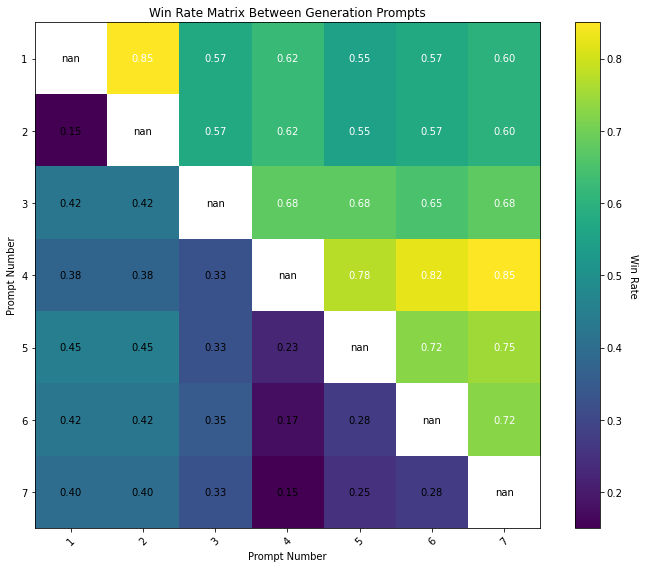

In [35]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np

# Convert the win_rate_matrix to a NumPy array for easier handling
matrix = np.array(win_rate_matrix)

# Determine the number of prompts
num_prompts = len(generation_prompts)

# Create a figure and axis for the heatmap
plt.figure(figsize=(10, 8))
im = plt.imshow(matrix, cmap='viridis')

# Add a colorbar to show the scale
cbar = plt.colorbar(im)
cbar.set_label('Win Rate', rotation=270, labelpad=15)

# Set the ticks and labels for x and y axes
prompt_indices = range(1, num_prompts + 1)
plt.xticks(ticks=np.arange(num_prompts), labels=prompt_indices)
plt.yticks(ticks=np.arange(num_prompts), labels=prompt_indices)

# Label the axes
plt.xlabel('Prompt Number')
plt.ylabel('Prompt Number')
plt.title('Win Rate Matrix Between Generation Prompts')

# Rotate the x-axis labels if needed
plt.xticks(rotation=45)

# Annotate each cell with the win rate value
for i in range(num_prompts):
    for j in range(num_prompts):
        text = f"{matrix[i, j]:.2f}"
        plt.text(j, i, text, ha='center', va='center',
                 color='white' if matrix[i, j] > 0.5 else 'black')

# Adjust layout for better spacing
plt.tight_layout()

# Display the heatmap
plt.show()